In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [2]:
users = pd.read_csv("takehome_users.csv",encoding = 'latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')

user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [5]:
engage.head()


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp')

In [7]:
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [8]:
# Resampling the dataset and counting up the number of visits
engage_v = engage.groupby('user_id').resample('1W').sum()

In [9]:
engage_v.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [10]:
# Dropping the doubled user_id, now index
engage_v = engage_v.drop('user_id',axis=1)

In [11]:
# Determining which weeks are considered active for the user
active = engage_v['visited'] >= 3
active = active * 1 #conver true false to values

In [12]:
active.head(15)


user_id  time_stamp
1        2014-04-27    0
2        2013-11-17    0
         2013-11-24    0
         2013-12-01    0
         2013-12-08    0
         2013-12-15    0
         2013-12-22    0
         2013-12-29    0
         2014-01-05    0
         2014-01-12    0
         2014-01-19    0
         2014-01-26    0
         2014-02-02    0
         2014-02-09    1
         2014-02-16    0
Name: visited, dtype: int64

In [13]:
# Grouping by user for joining. The value is active weeks.
active = active.groupby(level=0).sum()

In [14]:
active.head(15)


user_id
1      0
2      1
3      0
4      0
5      0
6      0
7      0
10    52
11     0
13     0
14     0
17     0
19     0
20     1
21     0
Name: visited, dtype: int64

In [15]:
# Creating dataframe for joining
active_users = pd.DataFrame(active, index=active.index)
active_users.columns = ['active_weeks']

In [16]:
active_users.head()


,active_weeks
user_id,
1,0
2,1
3,0
4,0
5,0


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [18]:
active_users.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   active_weeks  8823 non-null   int64
dtypes: int64(1)
memory usage: 137.9 KB


The users dataframe has far more object_id indicating that a number of users are not using the platform. As such, we'll need to use a left join to not lose that data.

In [19]:
# Joining dataframes
df = users.merge(active_users, how='left', left_on='object_id', right_index=True)


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  active_weeks                8823 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


In [21]:
# Adding an adopted user column based on active weeks
df['adopted_user'] = [1 if x >= 1 else 0 for x in df.active_weeks]

In [22]:
df.head(10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0.0,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,52.0,1


In [23]:
# Checking everything worked correctly
df.loc[df.active_weeks == 0].adopted_user.unique()

array([0])

In [24]:
df.loc[df.active_weeks >= 1].adopted_user.unique()


array([1])

In [25]:
df.adopted_user.unique()


array([0, 1])

In [26]:
# Dropping not needed features
# invited_by_user_id is handled in a creation_source option
# active weeks and time data defines the repsonse variable
# demographic data not needed
data = df.drop(['creation_time', 'name', 'email', 'last_session_creation_time', 
                'active_weeks', 'invited_by_user_id'],axis=1)

In [27]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   object_id                   12000 non-null  int64 
 1   creation_source             12000 non-null  object
 2   opted_in_to_mailing_list    12000 non-null  int64 
 3   enabled_for_marketing_drip  12000 non-null  int64 
 4   org_id                      12000 non-null  int64 
 5   adopted_user                12000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 562.6+ KB


In [28]:
# Creating dummy variables for the creation_source feature
data = pd.get_dummies(data=data, columns=['creation_source'])

In [29]:
data.head()


,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,0,1,0,0,0,0
1,2,0,0,1,1,0,1,0,0,0
2,3,0,0,94,0,0,1,0,0,0
3,4,0,0,1,0,1,0,0,0,0
4,5,0,0,193,0,1,0,0,0,0


Text(0, 0.5, 'Number of Users')

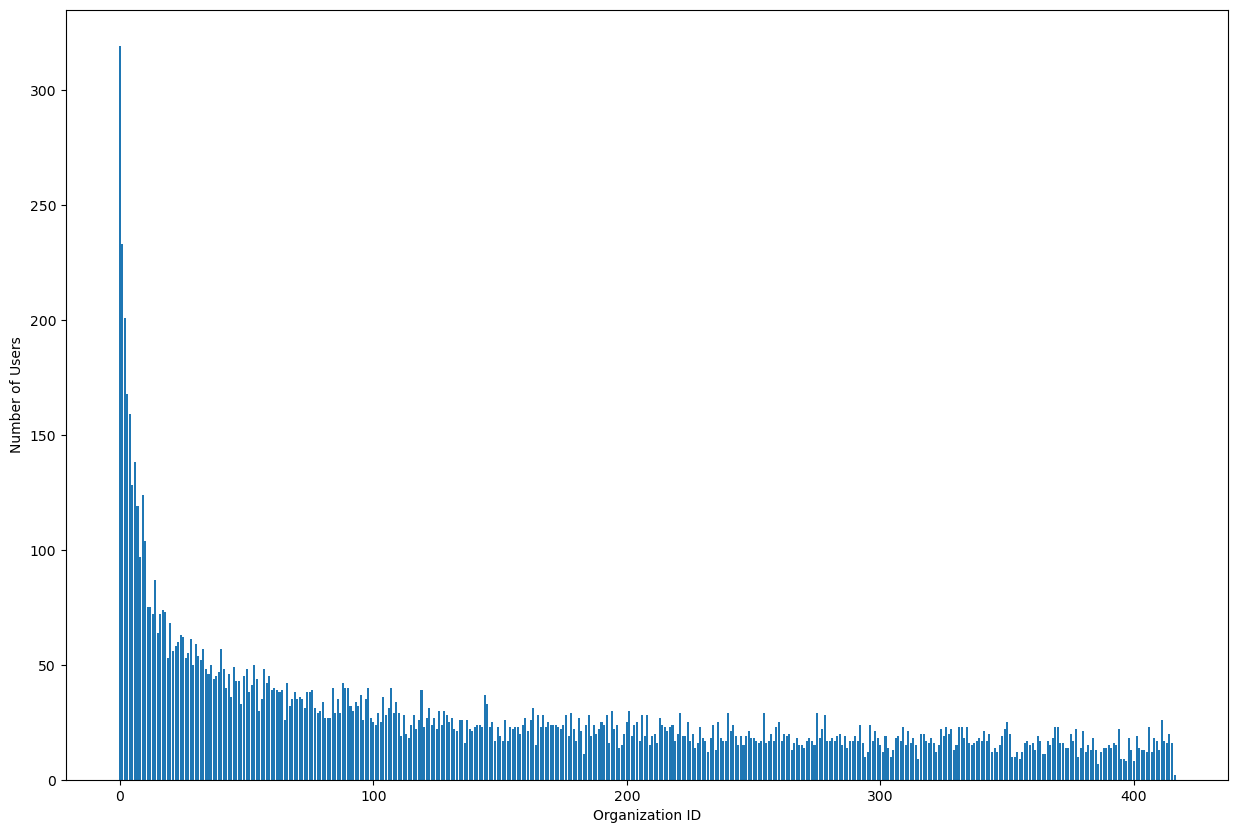

In [30]:
# The org_id is a bit all over the place and could negatively affect results. Let's visualize.
org_counts = data.org_id.value_counts()
plt.figure(figsize=(15,10))
plt.bar(org_counts.index, org_counts.values)
plt.xlabel('Organization ID')
plt.ylabel('Number of Users')

In [31]:
data.org_id.nunique()


417

There are far too many org_ids to provide solid analysis, we can group the data by org_id and cluster them by the number of adopted_user. This reduces dimensionality compared to creating a dummy variable for each org_id while retaining the major information of the data.



In [32]:
# Check how many clusters that would be
org = data.groupby('org_id').sum()
org.adopted_user.unique()

array([11, 14, 13,  9, 16,  8, 10,  7,  6,  4,  5,  3,  2,  1, 12,  0])

In [33]:
# Saving org_id for reference
orgs = data[['org_id']]
orgs.head()

,org_id
0,11
1,1
2,94
3,1
4,193


In [34]:
# Loop over the org_id and assign them a cluster by adopted_user number
org_group = []
for i in data['org_id']:
    group = org.loc[i,'adopted_user']
    org_group.append(group)
data['org_id'] = org_group

In [35]:
# Creating org_id/org_group reference df
orgs['org_group'] = org_group
orgs.head()

,org_id,org_group
0,11,7
1,1,14
2,94,6
3,1,14
4,193,3


In [36]:
# Checking
orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   org_id     12000 non-null  int64
 1   org_group  12000 non-null  int64
dtypes: int64(2)
memory usage: 187.6 KB


In [37]:
# Checking
test = orgs.groupby('org_id').nunique()
test.org_group.nunique()

1

Ok, all org_ids exist in only one grouping.

In [38]:
# Get dummy variables for the now categorized org_id
data = pd.get_dummies(data=data,columns=['org_id'])
data.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
0,1,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Set object_id as index as we don't need it for modeling
data = data.set_index('object_id')
data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:

# Checking the balance of the response variable
data.adopted_user.mean()


0.12041666666666667

In [41]:
# Split the data into train and test sets
X = data.drop('adopted_user', axis=1)
y = data.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)



In [44]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(max_features='sqrt')
para = {'n_estimators':[40,45,50,55,60],'learning_rate':[.01,0.02,0.03,0.04,0.05],
              'max_depth':[1,2,3,4,5]}
grid1 = GridSearchCV(estimator=grad_boost,param_grid=para,
                     scoring='accuracy',cv=5)
grid1.fit(X_train,y_train)
best_para_gra = grid1.best_params_
best_acc_gra = grid1.best_score_

print('The Tuned Paratmers ',best_para_gra,'Achieved %s Percent Accuracy' %(best_acc_gra*100))

The Tuned Paratmers  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 55} Achieved 87.93333333333334 Percent Accuracy


In [50]:
#importance of each features in descending order
gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=45,learning_rate=.05,max_depth= 3)
gbm.fit(X_train,y_train)
feature_coef = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coef.columns = list(X.columns)
feature_coef.index = ['GBM'] 
feature_coef.transpose().sort_values(by='GBM',ascending=False)


,GBM
creation_source_PERSONAL_PROJECTS,0.169076
org_id_0,0.144701
org_id_6,0.131981
org_id_1,0.115715
org_id_5,0.102063
creation_source_GUEST_INVITE,0.075450
org_id_12,0.062932
org_id_11,0.057030
org_id_2,0.028988
creation_source_SIGNUP_GOOGLE_AUTH,0.019084


In [51]:
# Series is easier to barplot
fi = pd.Series(gbm.feature_importances_, X.columns).sort_values(ascending=False)

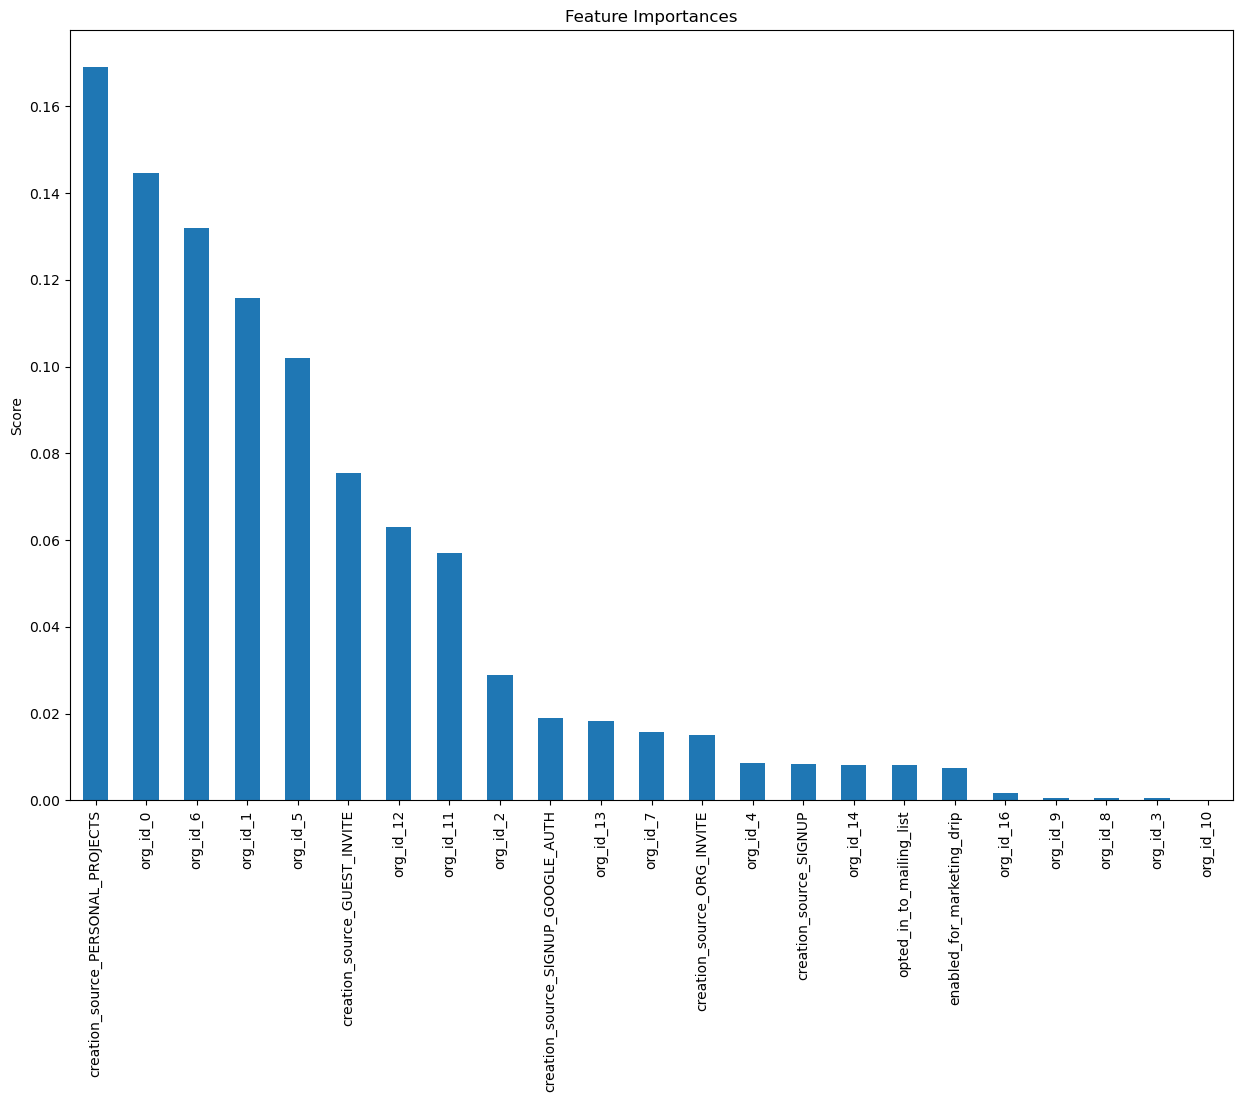

In [52]:
fi.plot(kind='bar', title='Feature Importances', figsize=[15,10])
plt.ylabel('Score')
plt.savefig('fi.png')